# Analyse des courbes d'excitation électronique simple

Le bloc de code ci-dessous permet d'installer les modules requis à l'analyse.

In [95]:
# ! python.exe -m pip install --upgrade pip
# ! pip install -r requirements.txt

In [96]:
from outils_analyse.fits import gaussian_fit, gaus
from outils_analyse.identification_des_pics import determiner_indexes_maximums_scipy
from outils_analyse.lecture_des_fichiers import lire_csv_a_3_colonnes, crop_pour_conserver_que_la_partie_avec_rampe
from outils_analyse.conversion_temps_en_potentiel import \
    calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe
import matplotlib.pyplot as plt
import os
import matplotlib
import numpy as np
from math import isnan
import re
from sigfig import round
# Grosseur du text dans les figures
matplotlib.rcParams.update({'font.size': 18})
# Chemin d'accès des figures produites
out_dir = os.path.join("graphiques", "anal_profond")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
import warnings
warnings.filterwarnings("ignore")
# Couleur des graphiques
import seaborn as sns
palette = sns.color_palette("muted")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

## Copie de l'analyse légère pour un pic
> Mettre les valeurs extraites à la place de `exemples_de_fichiers\exemple_de_donnees.csv`

In [97]:
file_name = os.path.join("data", "Montage_B_step6.2.csv")
valeurs_en_array = lire_csv_a_3_colonnes(file_name, 9)
valeurs_cropped_debutant_par_t0 = crop_pour_conserver_que_la_partie_avec_rampe(valeurs_en_array, 2, 0.05, 0.1)

debut = min(valeurs_cropped_debutant_par_t0[:,0])
valeurs_cropped_debutant_par_t0[:,0]-=debut

facteur_conversion_temps_en_potentiel = calculer_facteur_conversion_temps_en_potentiel_avec_mesure_rampe(
    valeurs_cropped_debutant_par_t0, 0, 2)

valeurs_avec_bonnes_unites = valeurs_cropped_debutant_par_t0.copy()
valeurs_avec_bonnes_unites[:, 0] = -facteur_conversion_temps_en_potentiel[0] * valeurs_cropped_debutant_par_t0[:, 0] 

facteur_valeur = facteur_conversion_temps_en_potentiel[0]
facteur_incertitude = facteur_conversion_temps_en_potentiel[1]

liste_des_indexes_des_pics = determiner_indexes_maximums_scipy(valeurs_avec_bonnes_unites, 1,distance_minimum=100)

valeurs_avec_bonnes_unites_determination_des_pics = valeurs_avec_bonnes_unites[liste_des_indexes_des_pics]
liste_des_indexes_des_pics = liste_des_indexes_des_pics

## Régression gaussienne et potentiel de contact

In [104]:
def rounding_peaks(peaks):
    all_values = []
    for i in range(0, 3):
        all_values.append(round(peaks[0][i], uncertainty=peaks[1][i], cutoff=5))
    return all_values

pic_params = []
start_index = []
end_index = []

for pic_index in range(4):
    pic_start = liste_des_indexes_des_pics[pic_index] - 50
    start_index.append(pic_start)
    pic_end = liste_des_indexes_des_pics[pic_index] + 50
    end_index.append(pic_end)

    # Appliquer la fonction Gaussian Fit
    pic = gaussian_fit(
        valeurs_avec_bonnes_unites[pic_start:pic_end, 0],
        valeurs_avec_bonnes_unites[pic_start:pic_end, 1],
        valeurs_avec_bonnes_unites_determination_des_pics[pic_index, 1],
        valeurs_avec_bonnes_unites_determination_des_pics[pic_index, 0],
        1
    )

    pic_params.append(pic)

# Afficher les valeurs mises à NaN pour chaque pic
for pic_index, pic in enumerate(pic_params):
    rounded_values = rounding_peaks(pic)
    print(f"Pic {pic_index + 1} - Amplitude: {rounded_values[0]}\t Moyenne: {rounded_values[1]}\t STD: {rounded_values[2]}\n")

Pic 1 - Amplitude: 0 ± 2000	 Moyenne: 0 ± 200000000	 STD: 0 ± 80000000

Pic 2 - Amplitude: 0.030 ± 0.003	 Moyenne: 7.43 ± 0.05	 STD: 0.47 ± 0.05

Pic 3 - Amplitude: 0.0744 ± 0.0006	 Moyenne: 12.560 ± 0.008	 STD: 0.826 ± 0.008

Pic 4 - Amplitude: 0.10655 ± 0.00008	 Moyenne: 17.745 ± 0.002	 STD: 1.129 ± 0.002



## Calcul du potentiel de contact

In [99]:
ecarts = np.diff(valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0])
ecart_std = np.std(ecarts)
ecart_moyen = np.mean(ecarts)
tension_u1 = 4.0
tension_u2 = valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0][0]
potentiel_contact = tension_u1 + tension_u2 - ecart_moyen
incertitude_u1 = 0.01
incertitude_u2 = facteur_incertitude
incertitude_potentiel_contact = np.sqrt(incertitude_u1**2 + incertitude_u2**2 + ecart_std**2)

## Graphique courants en fonction de la tension, emplacements approximatifs des maximums et fits gaussiens

Taux de variation de la tension du générateur de rampe en fonction du temps : -0.45 ± 0.01 [V/s]
Estimation des pics : 0 ± 200000000 ; 7.43 ± 0.05 ; 12.560 ± 0.008 ; 17.745 ± 0.002 [V]
Écart moyen entre chaque pic (V_{res}) : 5.0 ± 0.1 [V]
Potentiel de contact (W) : 1.6 ± 0.1 [V]


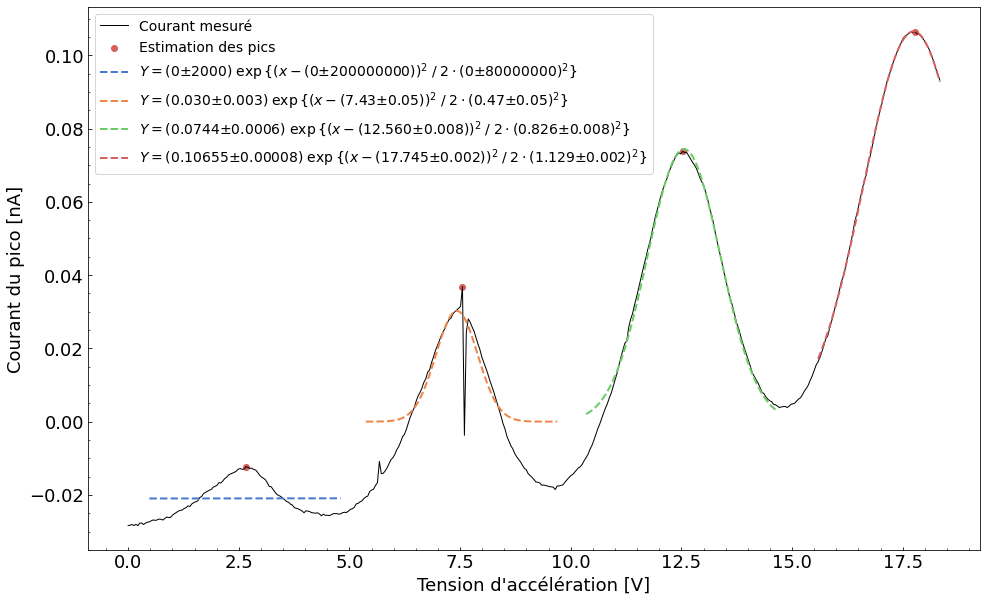

In [100]:
print(f"Taux de variation de la tension du générateur de rampe en fonction du temps : {round(facteur_valeur, facteur_incertitude)} [V/s]")
print("Estimation des pics :",
        f"{rounding_peaks(pic_params[0])[1]} ; {rounding_peaks(pic_params[1])[1]} ; {rounding_peaks(pic_params[2])[1]} ; {rounding_peaks(pic_params[3])[1]} [V]")
print(f"Écart moyen entre chaque pic (V_{{res}}) : {round(ecart_moyen, ecart_std)} [V]")
print(f"Potentiel de contact (W) : {round(potentiel_contact, incertitude_potentiel_contact)} [V]")

plt.figure(figsize=(16,10))

plt.plot(valeurs_avec_bonnes_unites[:, 0], valeurs_avec_bonnes_unites[:, 1], label="Courant mesuré",
        color="black", linewidth=1)

plt.scatter(valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 0],
        valeurs_avec_bonnes_unites[liste_des_indexes_des_pics, 1],
        label="Estimation des pics", color=palette[3], marker='o')

for pic_index, pic in enumerate(pic_params):
        rounded_values = rounding_peaks(pic)
        plt.plot(valeurs_avec_bonnes_unites[start_index[pic_index]:end_index[pic_index],0],
                gaus(valeurs_avec_bonnes_unites[start_index[pic_index]:end_index[pic_index],0],
                pic[0][0], pic[0][1], pic[0][2]),
        label=f"$Y = ({rounded_values[0]})\;\exp\{{(x-({rounded_values[1]}))^2\; /\; 2\cdot({rounded_values[2]})^2\}}$",
        linestyle="dashed", color=palette[pic_index], linewidth=2)

plt.xlabel("Tension d'accélération [V]")
plt.ylabel("Courant du pico [nA]")
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='both', direction='in')
plt.minorticks_on()

name, _ = os.path.splitext(os.path.basename(file_name))
#plt.savefig(os.path.join(out_dir, name + ".png"))
plt.show()